The source you are drawing inspiration from: https://www.dataquest.io/mission/75/improving-your-submission
Any additional ideas of your own that you are incorporating: If time permits, I would like to see how many of the captains and other crew members survived. Also, the effect of that info to our kaggle score

In [34]:
#Loading Datasets
import pandas as pd
titanic = pd.read_csv('train.csv')
titanic_test = pd.read_csv('test.csv')

In [35]:
#Because the cleanup is used on a lot of csv's
def csv_cleanup(csv):
    #Filling missing data with the most common one in that dataset
    csv.Age = csv.Age.fillna(csv.Age.median())
    csv.Fare = csv.Fare.fillna(csv.Fare.median())
    #Setting survey results like male/female/s/c/q with numbers for better calculation
    csv.loc[csv.Sex == "female", "Sex"] = 1
    csv.loc[csv.Sex == "male", "Sex"] = 0
    csv.Embarked = csv.Embarked.fillna("S")
    csv.loc[csv.Embarked == "S", "Embarked"] = 0
    csv.loc[csv.Embarked == "C", "Embarked"] = 1
    csv.loc[csv.Embarked == "Q", "Embarked"] = 2
    return csv
    
titanic = csv_cleanup(titanic)
titanic_test = csv_cleanup(titanic_test)

#### Following the Dataquest Random Tree tutorial

Random trees are basically columns split into sections/branches of trees. It is uaually helpful to use this method when the data is not linear. For example, Fare and Survival might not have an exact linear relation, i.e. Survival increasing with Fare. One problem with Random Trees is that it can easily overfit the data.

In [36]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

# Initialize our algorithm with the default paramters
# n_estimators is the number of trees we want to make
# min_samples_split is the minimum number of rows we need to make a split
# min_samples_leaf is the minimum number of samples we can have at the place where a tree branch ends (the bottom points of the tree)
alg = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=2, min_samples_leaf=1)

scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.800224466891


Next, we are changing parameters to make the algorithm more accurate. Because it is easy to overfit the data, having many branches is very helpful. What is does is making sure the score we get using averages of many predictions will improve in accuracy by using lots of branches.

In [37]:
alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=4, min_samples_leaf=2)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
# Take the mean of the scores (because we have one for each fold)
print(scores.mean())

0.819304152637


In [38]:
# Train the algorithm using all the training data
alg.fit(titanic[predictors], titanic["Survived"])

# Make predictions using the test set.
predictions = alg.predict(titanic_test[predictors])

# Create a new dataframe with only the columns Kaggle wants from the dataset.
submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

submission.to_csv("kagglea1.csv", index=False)

0.75120 Kaggle Score

Using the family size column. I have been trying to use this data to find something significant in the dataset. It would be interesting to see what this does.

In [39]:
# Generating a familysize column
titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]

# The .apply method generates a new series
titanic["NameLength"] = titanic["Name"].apply(lambda x: len(x))

import re

# A function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Get all the titles and print how often each one occurs.
titles = titanic["Name"].apply(get_title)
print(pd.value_counts(titles))

# Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
for k,v in title_mapping.items():
    titles[titles == k] = v

# Verify that we converted everything.
print(pd.value_counts(titles))

# Add in the title column.
titanic["Title"] = titles

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Countess      1
Ms            1
Lady          1
Jonkheer      1
Don           1
Mme           1
Capt          1
Sir           1
dtype: int64
1     517
2     183
3     125
4      40
5       7
6       6
7       5
10      3
8       3
9       2
dtype: int64


Initially, I talked about looking for the titles liek capt. etc to see how they survived. Not sure if that is statistically significant.

In [40]:
import operator

# A dictionary mapping family name to id
family_id_mapping = {}

# A function to get the id given a row
def get_family_id(row):
    # Find the last name by splitting on a comma
    last_name = row["Name"].split(",")[0]
    # Create the family id
    family_id = "{0}{1}".format(last_name, row["FamilySize"])
    # Look up the id in the mapping
    if family_id not in family_id_mapping:
        if len(family_id_mapping) == 0:
            current_id = 1
        else:
            # Get the maximum id from the mapping and add one to it if we don't have an id
            current_id = (max(family_id_mapping.items(), key=operator.itemgetter(1))[1] + 1)
        family_id_mapping[family_id] = current_id
    return family_id_mapping[family_id]

# Get the family ids with the apply method
family_ids = titanic.apply(get_family_id, axis=1)

# There are a lot of family ids, so we'll compress all of the families under 3 members into one code.
family_ids[titanic["FamilySize"] < 3] = -1

# Print the count of each unique id.
print(pd.value_counts(family_ids))

titanic["FamilyId"] = family_ids

-1      800
 14       8
 149      7
 63       6
 50       6
 59       6
 17       5
 384      4
 27       4
 25       4
 162      4
 8        4
 84       4
 340      4
 43       3
 269      3
 58       3
 633      2
 167      2
 280      2
 510      2
 90       2
 83       1
 625      1
 376      1
 449      1
 498      1
 588      1
dtype: int64


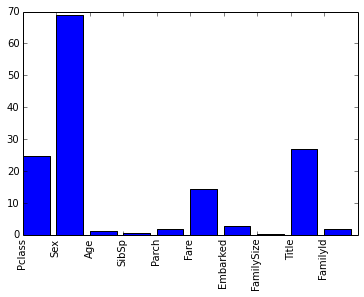

0.811447811448


In [41]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
%matplotlib inline

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic["Survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

# Pick only the four best features.
predictors = ["Pclass", "Sex", "Fare", "Title"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=8, min_samples_leaf=4)
# Compute the accuracy score for all the cross validation folds
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)

# Take the mean of the scores
print(scores.mean())

In [42]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
import numpy as np

# The algorithms we want to ensemble.
# We're using the more linear predictors for the logistic regression, and everything with the gradient boosting classifier.
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

# Initialize the cross validation folds
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_target = titanic["Survived"].iloc[train]
    full_test_predictions = []
    # Make predictions for each algorithm on each fold
    for alg, predictors in algorithms:
        # Fit the algorithm on the training data.
        alg.fit(titanic[predictors].iloc[train,:], train_target)
        # Select and predict on the test fold.  
        # The .astype(float) is necessary to convert the dataframe to all floats and avoid an sklearn error.
        test_predictions = alg.predict_proba(titanic[predictors].iloc[test,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)
    # Use a simple ensembling scheme -- just average the predictions to get the final classification.
    test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2
    # Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction.
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    predictions.append(test_predictions)

# Put all the predictions together into one array.
predictions = np.concatenate(predictions, axis=0)
predictions = pd.Series(predictions)

# Compute accuracy by comparing to the training data.
accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
print(accuracy)

0.278338945006


This score is pretty low in comparison to the one in the tutorial. I had to change it to pandas series. So not sure why this is effecting the printed accuracy.

Changing the testing data set in the same way

In [43]:
# First, we'll add titles to the test set.
titles = titanic_test["Name"].apply(get_title)
# We're adding the Dona title to the mapping, because it's in the test set, but not the training set
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2, "Dona": 10}
for k,v in title_mapping.items():
    titles[titles == k] = v
titanic_test["Title"] = titles
# Check the counts of each unique title.
print(pd.value_counts(titanic_test["Title"]))

# Now, we add the family size column.
titanic_test["FamilySize"] = titanic_test["SibSp"] + titanic_test["Parch"]

print(family_id_mapping)
family_ids = titanic_test.apply(get_family_id, axis=1)
family_ids[titanic_test["FamilySize"] < 3] = -1
titanic_test["FamilyId"] = family_ids
titanic_test["NameLength"] = titanic_test["Name"].apply(lambda x: len(x))

1     240
2      79
3      72
4      21
7       2
6       2
10      1
5       1
dtype: int64
{"O'Sullivan0": 426, 'Mangan0': 620, 'Lindqvist1': 543, 'Denkoff0': 297, 'Rouse0': 413, 'Berglund0': 207, 'Meo0': 142, 'Arnold-Franchi1': 49, 'Chronopoulos1': 71, 'Skoog5': 63, 'Widener2': 329, 'Pengelly0': 217, 'Goncalves0': 400, 'Myhrman0': 626, 'Beane1': 456, 'Moss0': 104, 'Carlsson0': 610, 'Nicholls2': 136, 'Jussila1': 110, 'Jussila0': 483, 'Long0': 632, 'Wheadon0': 33, 'Connolly0': 261, 'Hansen2': 680, 'Stephenson1': 493, 'Davies0': 336, 'Silven2': 359, 'Vanden Steen0': 311, 'Astor1': 571, 'Patchett0': 480, 'Johanson0': 184, 'Coleridge0': 220, 'Christmann0': 87, 'Carter3': 340, 'Compton2': 665, 'Carter1': 226, 'Turkula0': 414, 'Hassab0': 558, 'Saad0': 566, 'Mellors0': 208, 'Mamee0': 36, 'Madsen0': 119, 'Anderson0': 395, 'Kraeff0': 42, 'Robbins0': 468, 'Lundahl0': 522, 'Gilinski0': 490, 'Porter0': 107, 'Sdycoff0': 352, 'Green0': 204, 'Bishop1': 263, 'Sinkkonen0': 603, 'Otter0': 640, 'Dahl0'

In [44]:
predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

full_predictions = []
for alg, predictors in algorithms:
    # Fit the algorithm using the full training data.
    alg.fit(titanic[predictors], titanic["Survived"])
    # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error.
    predictions = alg.predict_proba(titanic_test[predictors].astype(float))[:,1]
    full_predictions.append(predictions)

# The gradient boosting classifier generates better predictions, so we weight it higher.
predictions = (full_predictions[0] * 3 + full_predictions[1]) / 4

predictions[predictions <= .5] = 0
predictions[predictions > .5] = 1
predictions = predictions.astype(int)
full_predictions.append(predictions)


submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })
submission.to_csv("kagglea2.csv", index=False)

Kaggle Score of 0.79904

Future Improvements: I would like to explore more by looking for other family members using the last name of people and comparing it to the number of family members they have on board. This can help in checking how accurate the Family_Size is in predictions. We can also look at the composition of the family. Compare that to Pclass + Sex. Or even Age (Child/Youth/Adult/Old) + gender.


#### Update:
Adding Random Forest Classifier

In [45]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
import numpy as np

# The algorithms we want to ensemble.
# We're using the more linear predictors for the logistic regression, and everything with the gradient boosting classifier.
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]],
    [RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=4, min_samples_leaf=2), ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]]
]

# Initialize the cross validation folds
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_target = titanic["Survived"].iloc[train]
    full_test_predictions = []
    # Make predictions for each algorithm on each fold
    for alg, predictors in algorithms:
        # Fit the algorithm on the training data.
        alg.fit(titanic[predictors].iloc[train,:], train_target)
        # Select and predict on the test fold.  
        # The .astype(float) is necessary to convert the dataframe to all floats and avoid an sklearn error.
        test_predictions = alg.predict_proba(titanic[predictors].iloc[test,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)
    # Use a simple ensembling scheme -- just average the predictions to get the final classification.
    test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2
    # Any value over .5 is assumed to be a 1 prediction, and below .5 is a 0 prediction.
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    predictions.append(test_predictions)

# Put all the predictions together into one array.
predictions = np.concatenate(predictions, axis=0)
predictions = pd.Series(predictions)

In [46]:
# First, we'll add titles to the test set.
titles = titanic_test["Name"].apply(get_title)
# We're adding the Dona title to the mapping, because it's in the test set, but not the training set
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2, "Dona": 10}
for k,v in title_mapping.items():
    titles[titles == k] = v
titanic_test["Title"] = titles
# Check the counts of each unique title.
print(pd.value_counts(titanic_test["Title"]))

# Now, we add the family size column.
titanic_test["FamilySize"] = titanic_test["SibSp"] + titanic_test["Parch"]

print(family_id_mapping)
family_ids = titanic_test.apply(get_family_id, axis=1)
family_ids[titanic_test["FamilySize"] < 3] = -1
titanic_test["FamilyId"] = family_ids
titanic_test["NameLength"] = titanic_test["Name"].apply(lambda x: len(x))

1     240
2      79
3      72
4      21
7       2
6       2
10      1
5       1
dtype: int64
{"O'Sullivan0": 426, 'Mangan0': 620, 'Lindqvist1': 543, 'Denkoff0': 297, 'Sincock0': 813, 'Rouse0': 413, 'Berglund0': 207, 'Meo0': 142, 'Arnold-Franchi1': 49, 'Chronopoulos1': 71, 'Skoog5': 63, 'Walcroft0': 897, 'Widener2': 329, 'Pengelly0': 217, 'Goncalves0': 400, 'Andersen0': 829, 'Myhrman0': 626, 'Beane1': 456, 'Moss0': 104, 'Carlsson0': 610, 'Nicholls2': 136, 'Jussila1': 110, 'Jussila0': 483, 'Peltomaki0': 725, 'Long0': 632, 'Cassebeer0': 809, 'Portaluppi0': 858, 'Wheadon0': 33, 'Connolly0': 261, 'Hansen2': 680, 'Stephenson1': 493, 'Howard0': 862, 'Smyth0': 805, 'Davies0': 336, 'Silven2': 359, 'Vanden Steen0': 311, 'Sadowitz0': 878, 'Astor1': 571, 'Patchett0': 480, 'Denbury0': 891, 'Johanson0': 184, 'Coleridge0': 220, 'Christmann0': 87, 'Carter3': 340, 'Compton2': 665, 'Carter1': 226, 'Turkula0': 414, 'Lindeberg-Lind0': 793, 'Hassab0': 558, 'Badman0': 755, 'Aronsson0': 914, 'Saad0': 566, 'M

In [47]:
predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]],
    [RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=4, min_samples_leaf=2), ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]]
]

full_predictions = []
for alg, predictors in algorithms:
    # Fit the algorithm using the full training data.
    alg.fit(titanic[predictors], titanic["Survived"])
    # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error.
    predictions = alg.predict_proba(titanic_test[predictors].astype(float))[:,1]
    full_predictions.append(predictions)

# The gradient boosting classifier generates better predictions, so we weight it higher.
predictions = (full_predictions[0] * 3 + full_predictions[1]) / 4

predictions[predictions <= .5] = 0
predictions[predictions > .5] = 1
predictions = predictions.astype(int)
full_predictions.append(predictions)


submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })
submission.to_csv("kagglea3.csv", index=False)

I think there is a lot to explore even with just one algorithm. In the tutorial, we were just given the values for the arguments of the algorithms that will work for the data the best, given the size. It would be interesting to see how I would have tried to do that. 